<a href="https://colab.research.google.com/github/pvalluri09/FraudGuardR/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn pandas numpy matplotlib seaborn

In [2]:
import random
import pandas as pd
import numpy as np
import re
import heapq
import uuid
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
billing_issues = [
    "charged twice", "refund request", "invoice incorrect",
    "payment failed", "subscription renewal issue",
    "billing address update", "credit card declined",
    "unexpected charge", "pricing discrepancy"
]

technical_issues = [
    "app not loading", "server down", "login failed",
    "500 internal error", "feature not working",
    "API timeout", "database crash",
    "slow performance", "bug in dashboard"
]

legal_issues = [
    "contract agreement", "terms and conditions",
    "data privacy compliance", "legal notice",
    "service agreement clarification",
    "GDPR request", "data deletion request",
    "liability concern"
]

urgency_words = [
    "ASAP", "urgent", "immediately", "critical",
    "right now", "as soon as possible"
]

noise_words = [
    "since yesterday", "after update", "in production",
    "for multiple users", "this morning", "in staging"
]

typos = {
    "payment": "paymnt",
    "server": "servr",
    "agreement": "agreemnt",
    "subscription": "subscrption"
}

def introduce_typo(text):
    for correct, wrong in typos.items():
        if random.random() < 0.1:
            text = text.replace(correct, wrong)
    return text

def generate_ticket(issue_list, label):
    issue = random.choice(issue_list)
    noise = random.choice(noise_words)

    text = f"We are facing {issue} {noise}"

    # 25% mixed category noise
    if random.random() < 0.25:
        mixed = random.choice(billing_issues + technical_issues + legal_issues)
        text += f" and also {mixed}"

    # 30% urgency injection
    if random.random() < 0.3:
        text += f". This is {random.choice(urgency_words)}"

    text = introduce_typo(text)
    return text, label

data = []

for _ in range(6000):
    data.append(generate_ticket(billing_issues, "Billing"))
    data.append(generate_ticket(technical_issues, "Technical"))
    data.append(generate_ticket(legal_issues, "Legal"))

df = pd.DataFrame(data, columns=["text", "category"])
print("Dataset size:", df.shape)
df.head()

Dataset size: (18000, 2)


,text,category
0,We are facing pricing discrepancy since yesterday,Billing
1,We are facing API timeout this morning,Technical
2,We are facing contract agreement this morning ...,Legal
3,We are facing payment failed since yesterday a...,Billing
4,We are facing app not loading in staging,Technical


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["category"],
    test_size=0.2,
    random_state=42,
    stratify=df["category"]
)

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_features=15000,
        stop_words="english"
    )),
    ("clf", LogisticRegression(max_iter=500))
])

model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

     Billing       1.00      1.00      1.00      1200
       Legal       1.00      1.00      1.00      1200
   Technical       1.00      1.00      1.00      1200

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



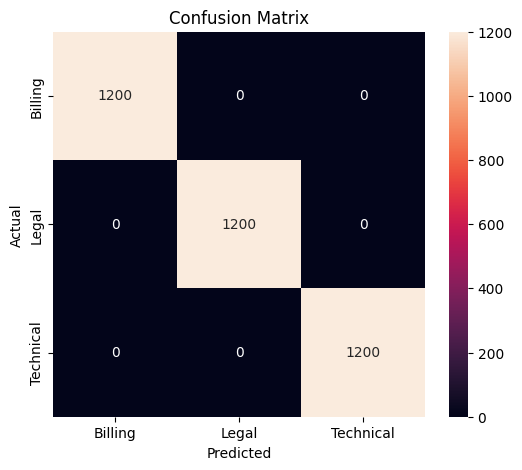

In [5]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [6]:
urgent_keywords = [
    "urgent", "asap", "immediately",
    "critical", "right now",
    "broken", "not working",
    "failed", "down", "error"
]

def detect_urgency(text):
    text = text.lower()
    for word in urgent_keywords:
        if re.search(rf"\b{word}\b", text):
            return 1  # High priority
    return 5  # Normal priority

In [8]:
# Initialize queue and counter
ticket_queue = []
counter = 0  # tie-breaker to avoid dict comparison in heap


def ingest_ticket(text):
    global counter

    category = model.predict([text])[0]
    priority = detect_urgency(text)

    ticket = {
        "ticket_id": str(uuid.uuid4()),
        "text": text,
        "category": category,
        "priority": priority
    }

    # Push (priority, counter, ticket)
    heapq.heappush(ticket_queue, (priority, counter, ticket))
    counter += 1

    return ticket


def process_next_ticket():
    if ticket_queue:
        return heapq.heappop(ticket_queue)[2]  # index 2 = ticket
    return None

In [9]:
# Simulate 20 random incoming tickets
for _ in range(20):
    sample_text = df.sample(1)["text"].values[0]
    ticket = ingest_ticket(sample_text)
    print("Ingested:", ticket["category"], "| Priority:", ticket["priority"])

print("\nProcessing Tickets in Priority Order:\n")

while ticket_queue:
    ticket = process_next_ticket()
    print("Processed:",
          "| Category:", ticket["category"],
          "| Priority:", ticket["priority"])

Ingested: Technical | Priority: 1
Ingested: Billing | Priority: 1
Ingested: Legal | Priority: 5
Ingested: Billing | Priority: 1
Ingested: Billing | Priority: 1
Ingested: Technical | Priority: 1
Ingested: Legal | Priority: 1
Ingested: Technical | Priority: 5
Ingested: Billing | Priority: 1
Ingested: Billing | Priority: 5
Ingested: Legal | Priority: 5
Ingested: Legal | Priority: 5
Ingested: Technical | Priority: 1
Ingested: Technical | Priority: 1
Ingested: Billing | Priority: 5
Ingested: Billing | Priority: 5
Ingested: Billing | Priority: 5
Ingested: Legal | Priority: 1
Ingested: Technical | Priority: 1
Ingested: Technical | Priority: 5

Processing Tickets in Priority Order:

Processed: | Category: Technical | Priority: 1
Processed: | Category: Billing | Priority: 1
Processed: | Category: Billing | Priority: 1
Processed: | Category: Billing | Priority: 1
Processed: | Category: Technical | Priority: 1
Processed: | Category: Legal | Priority: 1
Processed: | Category: Billing | Priority: 1

In [11]:
realistic_tests = [
    "My payment failed and the dashboard is not loading",
    "Need refund and the API is timing out",
    "Legal agreement issue with billing invoice",
    "Server crash affecting subscription renewals",
    "GDPR compliance request for deleted account"
]

probs = model.predict_proba(realistic_tests)
preds = model.predict(realistic_tests)

for i, text in enumerate(realistic_tests):
    print("\nText:", text)
    print("Predicted Category:", preds[i])

    # Confidence score (max probability)
    confidence = np.max(probs[i])
    print("Confidence:", round(confidence, 4))

    # Show all class probabilities
    for cls, prob in zip(model.classes_, probs[i]):
        print(f"  {cls}: {round(prob, 4)}")

    # Urgency
    urgency = detect_urgency(text)
    print("Urgency Priority:", urgency)


Text: My payment failed and the dashboard is not loading
Predicted Category: Billing
Confidence: 0.6865
  Billing: 0.6865
  Legal: 0.0191
  Technical: 0.2944
Urgency Priority: 1

Text: Need refund and the API is timing out
Predicted Category: Billing
Confidence: 0.5606
  Billing: 0.5606
  Legal: 0.0265
  Technical: 0.4129
Urgency Priority: 5

Text: Legal agreement issue with billing invoice
Predicted Category: Billing
Confidence: 0.5958
  Billing: 0.5958
  Legal: 0.3742
  Technical: 0.03
Urgency Priority: 5

Text: Server crash affecting subscription renewals
Predicted Category: Technical
Confidence: 0.965
  Billing: 0.0246
  Legal: 0.0104
  Technical: 0.965
Urgency Priority: 5

Text: GDPR compliance request for deleted account
Predicted Category: Legal
Confidence: 0.9613
  Billing: 0.0224
  Legal: 0.9613
  Technical: 0.0163
Urgency Priority: 5
